In [1]:
!python --version

Python 3.12.3


In [46]:
!nvidia-smi

Mon Nov 24 00:55:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.47                 Driver Version: 572.47         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              1W /   40W |     807MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
SEED = 42
N_EPOCHS = 10
BATCH_SIZE = 64
SIZE = 224

In [4]:
class PlantDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_src = f"data/images/{row.image_id}.jpg"
        image = Image.open(image_src).convert("RGB")

        labels = row[['healthy', 'multiple_diseases', 'rust', 'scab']].values.astype(float)
        labels = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

In [5]:
transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transforms_valid = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [6]:
import pandas as pd

train_df = pd.read_csv(r'data\train.csv')
train_df.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [7]:
from sklearn.model_selection import train_test_split

label_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

train_df[label_cols] = train_df[label_cols].astype(int)
train_df['combined'] = train_df[label_cols].astype(str).agg('_'.join, axis=1)

train_df, valid_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['combined'],
    random_state=42
)

In [8]:
train_df.shape[0]

1456

In [9]:
valid_df.shape[0]

365

In [22]:
train_dataset = PlantDataset(train_df, transform=transforms_train)
valid_dataset = PlantDataset(valid_df, transform=transforms_valid)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

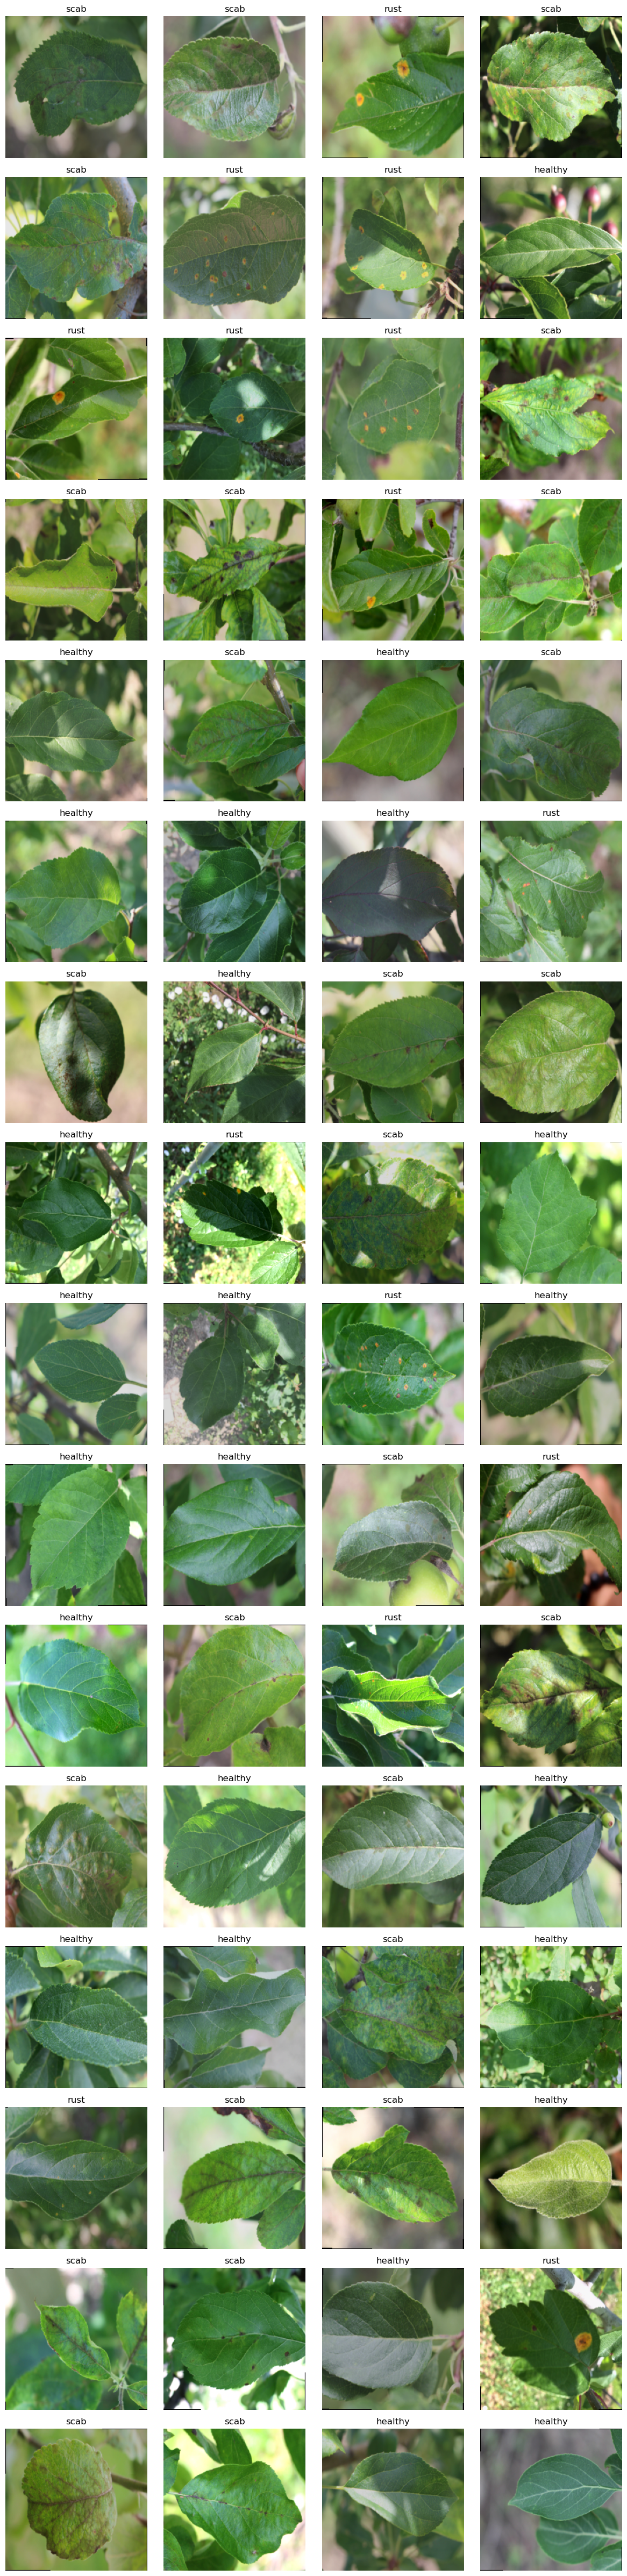

In [23]:
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean

images, labels = next(iter(train_loader))
batch_size = images.shape[0]
cols = 4
rows = (batch_size + cols - 1) // cols

plt.figure(figsize=(12, rows * 3))

for i in range(min(batch_size, rows * cols)):
    plt.subplot(rows, cols, i + 1)

    img = unnormalize(images[i])
    img = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    
    lbl = labels[i].cpu().numpy()
    index_label = lbl.tolist().index(1.0)
    label = label_cols[index_label]
    plt.title(f"{label}")

    plt.axis("off")

plt.tight_layout()
plt.show()

In [26]:
class PlantModel(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.backbone = torchvision.models.resnet18(pretrained=True)
        in_features = self.backbone.fc.in_features
        
        # remove old classifier
        self.backbone.fc = nn.Identity()

        # new layer
        self.logit = nn.Linear(in_features, num_classes)

        # freeze all backbone
        for p in self.backbone.parameters():
            p.requires_grad = False

    def forward(self, x):
        features = self.backbone(x)
        out = F.dropout(features, 0.25, training=self.training)
        return self.logit(out)

In [49]:
def count_trainable(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = PlantModel(num_classes=len(label_cols))
model = model.to(device)
print("Trainable parameters:", count_trainable(model))

Trainable parameters: 2052


In [50]:
from tqdm import tqdm

class CancelTrainException(Exception): pass

class LRFinder:

    def __init__(self, model, data_loader, loss_func, opt, lr_range, max_iter):
        self.lrs = []
        self.losses = []
        self.model = model
        self.data_loader = data_loader
        self.loss_func = loss_func
        self.opt = opt
        self.lr_range = lr_range
        self.max_iter = max_iter

    def run(self):
        best_loss = 1e9
        i=0
        while i<self.max_iter:
          print(f"I: {i}")
          for xb, yb in self.data_loader:

            # move to cuda
            xb, target = xb.cuda(), yb.cuda()
            pred = model(xb)

            # begin batch
            pos = i/self.max_iter
            i+=1
            lr = self.lr_range[0]*(self.lr_range[1]/self.lr_range[0])**pos
            for pg in self.opt.param_groups: pg['lr'] = lr

            loss = self.loss_func(pred, target)
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

            # after step
            if (loss.item() > best_loss*10) or (i==self.max_iter): raise CancelTrainException()
            if loss.item() < best_loss: best_loss = loss.item()

            # after batch
            self.lrs.append(lr)
            self.losses.append(loss.item())

    def plot_lr(self):
        # plot lr x loss
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [51]:
lr_finder = LRFinder(model = model, 
                     data_loader = train_loader, 
                     loss_func = nn.BCEWithLogitsLoss(), 
                     opt = optim.Adam(model.parameters(),lr=1e-2), 
                     lr_range = [1e-6,1],
                     max_iter = 100)

In [52]:
lr_finder.run()

I: 0
I: 23
I: 46
I: 69
I: 92


CancelTrainException: 

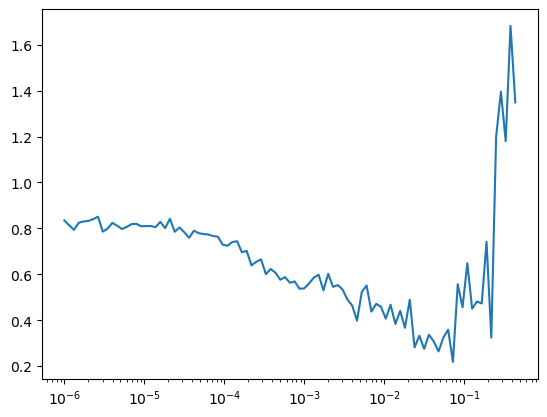

In [53]:
lr_finder.plot_lr()

In [55]:
from torch.optim.lr_scheduler import CosineAnnealingLR


model = PlantModel(num_classes=len(label_cols))
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-1)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS, eta_min=1e-4)

In [56]:
from sklearn.metrics import roc_auc_score

def compute_auc(y_true, y_pred, average="macro"):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()
    
    try:
        auc = roc_auc_score(y_true, y_pred, average=average)
    except ValueError:
        # Occurs if only one class present in y_true
        auc = None
    return auc

train_losses, valid_losses = [], []
train_aucs, valid_aucs = [], []

for epoch in range(N_EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0.0
    all_train_probs, all_train_labels = [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        all_train_probs.append(torch.sigmoid(outputs).detach().cpu())
        all_train_labels.append(labels.detach().cpu())

    scheduler.step()

    all_train_probs = torch.cat(all_train_probs)
    all_train_labels = torch.cat(all_train_labels)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_auc = compute_auc(all_train_labels, all_train_probs)

    train_losses.append(epoch_train_loss)
    train_aucs.append(epoch_train_auc)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    all_val_probs, all_val_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS} [Valid]"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            all_val_probs.append(torch.sigmoid(outputs).cpu())
            all_val_labels.append(labels.cpu())

    all_val_probs = torch.cat(all_val_probs)
    all_val_labels = torch.cat(all_val_labels)
    epoch_val_loss = val_loss / len(valid_loader.dataset)
    epoch_val_auc = compute_auc(all_val_labels, all_val_probs)

    valid_losses.append(epoch_val_loss)
    valid_aucs.append(epoch_val_auc)

    print(f"Epoch [{epoch+1}/{N_EPOCHS}] "
            f"Train Loss: {epoch_train_loss:.4f}, AUC: {epoch_train_auc:.4f} | "
            f"Val Loss: {epoch_val_loss:.4f}, AUC: {epoch_val_auc:.4f}")

Epoch 1/10 [Valid]: 100%|██████████| 6/6 [00:25<00:00,  4.27s/it]


Epoch [1/10] Train Loss: 3.3240, AUC: 0.6591 | Val Loss: 0.5935, AUC: 0.8967


Epoch 2/10 [Valid]: 100%|██████████| 6/6 [00:24<00:00,  4.06s/it]


Epoch [2/10] Train Loss: 0.6562, AUC: 0.8592 | Val Loss: 0.5047, AUC: 0.8972


Epoch 3/10 [Valid]: 100%|██████████| 6/6 [00:24<00:00,  4.05s/it]


Epoch [3/10] Train Loss: 0.5049, AUC: 0.8819 | Val Loss: 0.5466, AUC: 0.9018


Epoch 4/10 [Valid]: 100%|██████████| 6/6 [00:26<00:00,  4.35s/it]


Epoch [4/10] Train Loss: 0.5126, AUC: 0.8682 | Val Loss: 0.3995, AUC: 0.9056


Epoch 5/10 [Valid]: 100%|██████████| 6/6 [00:24<00:00,  4.06s/it]


Epoch [5/10] Train Loss: 0.4134, AUC: 0.8979 | Val Loss: 0.4188, AUC: 0.9128


Epoch 6/10 [Valid]: 100%|██████████| 6/6 [00:24<00:00,  4.05s/it]


Epoch [6/10] Train Loss: 0.4230, AUC: 0.9028 | Val Loss: 0.3035, AUC: 0.9161


Epoch 7/10 [Valid]: 100%|██████████| 6/6 [00:25<00:00,  4.33s/it]


Epoch [7/10] Train Loss: 0.4194, AUC: 0.9006 | Val Loss: 0.4731, AUC: 0.9231


Epoch 8/10 [Valid]: 100%|██████████| 6/6 [00:26<00:00,  4.37s/it]


Epoch [8/10] Train Loss: 0.4322, AUC: 0.8980 | Val Loss: 0.3029, AUC: 0.9236


Epoch 9/10 [Valid]: 100%|██████████| 6/6 [00:24<00:00,  4.05s/it]


Epoch [9/10] Train Loss: 0.3408, AUC: 0.9187 | Val Loss: 0.2689, AUC: 0.9229


Epoch 10/10 [Valid]: 100%|██████████| 6/6 [00:24<00:00,  4.09s/it]

Epoch [10/10] Train Loss: 0.3051, AUC: 0.9322 | Val Loss: 0.2582, AUC: 0.9227


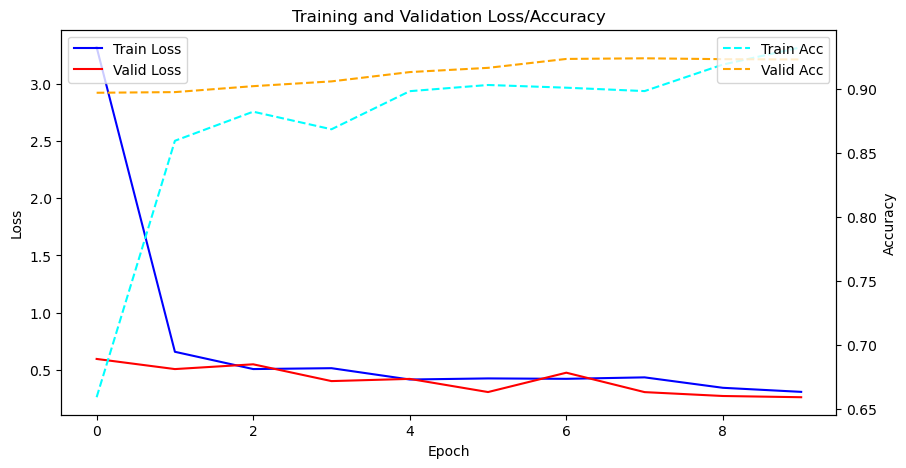

In [57]:
fig, ax1 = plt.subplots(figsize=(10,5))
    
ax1.plot(train_losses, label="Train Loss", color="blue")
ax1.plot(valid_losses, label="Valid Loss", color="red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(train_aucs, label="Train Acc", color="cyan", linestyle="--")
ax2.plot(valid_aucs, label="Valid Acc", color="orange", linestyle="--")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="upper right")

plt.title("Training and Validation Loss/Accuracy")
plt.show()

In [58]:
torch.save(model.state_dict(), "tf_resnet18_10.pth")